In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from model import Attention, precompute_freqs_cis, Transformer, ModelArgs, Model

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
attn = Attention(1, 512, 64, 16, 8)

In [5]:
x = torch.randn(10, 100, 512).to(torch.bfloat16)
freqs_cls = precompute_freqs_cis(64, 100)

In [6]:
attn(x, freqs_cls, None).shape

torch.Size([10, 100, 512])

In [7]:
args = ModelArgs(vocab_size=1024)

In [8]:
model = Transformer(args).to('cuda')

In [9]:
x = torch.randint(0, 1024, (5, 32))

In [10]:
model(x, 0, None)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [ ]:
import torch.nn as nn
test = nn.Parameter(torch.ones((3,4), dtype=torch.bfloat16))
test.dtype

torch.bfloat16

In [ ]:
g = [torch.randn(10, 512).unsqueeze(1), torch.randn(10, 512).unsqueeze(1), torch.randn(10, 512).unsqueeze(1)]
torch.cat(g, dim=1).shape

torch.Size([10, 3, 512])

In [ ]:
x = torch.randint(0, 1024,(10, 500)).to('cuda')
y = torch.randint(0, 1024,(10, 2048)).to('cuda')
model = Model(args).to('cuda')
model.train_forward(x, y).shape

torch.Size([10, 2048, 1024])

In [10]:
from tokenizers import Tokenizer

In [11]:
tok = Tokenizer.from_file('../tokenizer/text_tokenizer.json')

In [10]:
from tokenizer import TokenManager

In [11]:
test_input = [
    {
        "type": "image",
        "content": "assets/stop_sign.png"
    }
]

In [12]:
tm = TokenManager()

VQModel loaded from ../tokenizer/vqgan.ckpt


In [4]:
img = tm.tokenize(test_input)[2:-2]

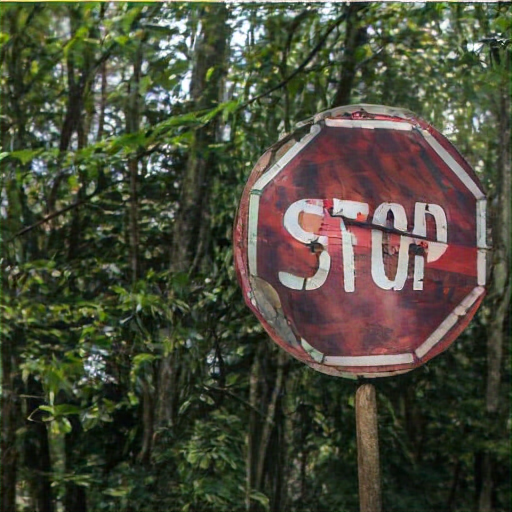

In [5]:
tm.image_tokenizer.pil_from_img_toks(tm.translation.convert_bpe2img(img.to('cuda')))

In [20]:
img.device

device(type='cpu')

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from pprint import pprint
import sentencepiece as spm
import urllib.request
import csv
import numpy as np
from einops import rearrange, reduce, repeat
from torch.cuda import amp
from tqdm import tqdm
import wandb
import time
import copy
from collections import defaultdict
from sklearn.metrics import mean_squared_error
import joblib
import gc
import os
from icecream import ic
from sklearn.model_selection import train_test_split
import os

In [1]:
import torch
import json
from datasets import load_dataset
from torch.utils.data import DataLoader
from tokenizer import TokenManager
from vocab import VocabInfo
tm = TokenManager()
vocab = VocabInfo(json.load(open('../tokenizer/text_tokenizer.json'))['model']['vocab'])

VQModel loaded from ../tokenizer/vqgan.ckpt


In [15]:
en = load_dataset("allenai/c4", "en", split='train', streaming=True)

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

In [17]:
def encode(seq):
    return {'text':tm.tokenize_text(seq['text'])}
def collate(samples):
    max_len = max([len(sample['text']) for sample in samples])
    collate = []
    length = []
    for sample in samples:
        diff = max_len - len(sample['text'])
        if diff > 0:
            pad = torch.ones(size=(diff,), dtype=torch.int) * vocab.pad_id
            collate.append(torch.cat([sample['text'], pad], dim=0))
        else:
            collate.append(sample['text'])
        length.append(len(sample['text']))
    return {'text': torch.stack(collate), 'length': torch.Tensor(length)}
            
dataset = en.map(encode).with_format(type='torch')
assert isinstance(dataset, torch.utils.data.IterableDataset)
dataloader = DataLoader(dataset, batch_size=2, collate_fn=collate)

In [18]:
len(dataloader)

TypeError: object of type 'IterableDataset' has no len()

In [10]:
print(next(iter(dataset)))

{'text': tensor([    0, 38189, 18643, 51924, 21198, 35591, 26582, 16672, 21103, 16663,
        18895, 16384, 16582, 19930, 16732, 17137, 16671, 16969, 17607, 16767,
        18065, 30047, 51924, 16414, 17332, 16868, 16807, 16647, 19560, 16395,
        17646, 16811, 16709, 16912, 27784, 17178, 16397, 20279, 16395, 19118,
        16604, 16401, 16401, 19566, 21004, 18671, 21198, 51924, 36765, 16395,
        26051, 25128, 16708, 16815, 57364, 16765, 16668, 56277, 36185, 16397,
        17046, 16868, 16703, 21641, 16641, 46870, 17743, 17568, 16715, 18594,
        16929, 19909, 16671, 16969, 17607, 16734, 16914, 45333, 20043, 16397,
        16582, 17611, 16868, 22572, 16732, 18531, 16732, 17109, 16671, 17039,
        16671, 26749, 16672, 16641, 49141, 21371, 51924, 21667, 16395, 17789,
        22658, 16395, 35135, 16395, 21106, 22981, 16395, 24309, 22525, 16674,
        31332, 19509, 16395, 20944, 17295, 26982, 16674, 18970, 17624, 16397,
        16582, 16853, 17985, 16671, 16703, 16672, 16647

/root/app/anaconda3/envs/cv/lib/python3.10/site-packages/datasets/formatting/torch_formatter.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(value, **{**default_dtype, **self.torch_tensor_kwargs})


In [5]:
print(dataloader.__len__())

NameError: name 'dataloader' is not defined

In [6]:
for d in dataloader:
    print(d)
    break

{'text': tensor([[    0, 44204, 16672, 16604, 16390, 30234, 26559, 18126, 34381, 16604,
         16391, 16400, 16399, 16397, 16406, 16392, 16390, 18358, 16809, 23856,
         49866, 16407, 16406, 16395, 18415, 16604, 16401, 16399, 16395, 16604,
         16401, 16399, 16400, 16401, 16397, 16582, 16424, 16390, 16690, 17497,
         16641, 16604, 16404, 16399, 16399, 31235, 22207, 19786, 16674, 16641,
         16604, 16401, 16403, 16399, 31235, 44351, 16397, 16582, 18811, 18387,
         16671, 30092, 17655, 28951, 28450, 17226, 16390, 16460, 18201, 16647,
         20341, 16604, 16385, 19659, 18010, 18692, 16709, 28951, 16604, 16446,
         16446, 16446, 16446, 16671, 30092, 16385, 16582, 18129, 16687, 22976,
         16390, 16467, 16807, 16671, 16829, 16721, 16384, 16384, 16384, 16582,
         22164, 20385, 16785, 16985, 16668, 18300, 17329, 28502, 16661, 16671,
         16647, 18568, 16414, 16582, 28861, 40910, 46884, 17683, 33121, 16671,
         20600, 16917, 19786, 16671, 16647,

In [34]:
loader = DataLoader(en['train'], batch_size=1)

In [40]:
loader.next()

AttributeError: 'DataLoader' object has no attribute 'next'

In [58]:
a = iter(loader)
next(a)


{'text': ['Beginners BBQ Class Taking Place in Missoula!\nDo you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. He will be teaching a beginner level class for everyone who wants to get better with their culinary skills.\nHe will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information.\nThe cost to be in the class is $35 per person, and for spectators it is free. Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.'],
 'timestamp': ['2019-04-25 12:57:54'],
 'url': ['https://klyq.com/beginners-bbq-class-taking-place-in-missoula/']}

In [61]:
loader.__len__()

TypeError: object of type 'IterableDataset' has no len()

In [54]:

dataset = en['train'].map(my_encode, batched=True)
dataset

IterableDataset({
    features: Unknown,
    n_shards: 1024
})

IterableDatasetDict({
    train: IterableDataset({
        features: ['text', 'timestamp', 'url'],
        n_shards: 1024
    })
    validation: IterableDataset({
        features: ['text', 'timestamp', 'url'],
        n_shards: 8
    })
})

In [3]:
from dataset import Dataset_C4
c4 = Dataset_C4(tm)

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

In [4]:
len(c4.train_loader)

TypeError: object of type 'IterableDataset' has no len()

In [23]:
from tqdm import tqdm
for i, d in tqdm(enumerate(c4.train_loader)):
    print(d)
    test = d
    break

0it [00:00, ?it/s]

{'text': tensor([[    0, 17635, 18074,  ...,     1,     1,     1],
        [    0, 18001, 17366,  ...,     1,     1,     1],
        [    0, 41307, 31470,  ...,     1,     1,     1],
        ...,
        [    0, 16400, 16408,  ...,     1,     1,     1],
        [    0, 17635, 46631,  ...,     1,     1,     1],
        [    0, 16853, 29397,  ...,     1,     1,     1]]), 'length': tensor([ 832.,  126., 1441.,  283.,  226.,   82.,  430., 1550.,  170.,  522.,
         493.,  553., 4148.,  292.,  221., 1133.])}


In [25]:
tt = test['text']
tl = test['length']

In [78]:
tt = torch.randn((3, 10))
tl = torch.tensor([5,2,3])
tt

tensor([[-0.1979,  0.6623, -1.6229,  0.7377, -1.0116, -0.4121,  0.9146, -1.6179,
          0.3437,  1.0961],
        [ 0.1467, -0.6037,  1.3526,  1.3352,  2.2812,  1.6722, -0.0862,  1.9115,
         -0.0796, -0.9072],
        [-0.1273, -0.0663, -1.8732,  0.4782, -0.9068, -0.6476, -0.5316,  1.3528,
         -1.4393,  0.3066]])

In [41]:
torch.gather(tt, 1, tl)

tensor([[0.1629],
        [0.1652],
        [0.3261]])

In [42]:
tl.expand(10, -1)

RuntimeError: The expanded size of the tensor (10) must match the existing size (3) at non-singleton dimension 0.  Target sizes: [10, -1].  Tensor sizes: [3, 1]

In [43]:
tl

tensor([[5],
        [2],
        [3]])

In [44]:
tri = torch.triu(torch.ones(10, 10), diagonal=1)

In [45]:
tri

tensor([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [48]:
tri[tl]

tensor([[0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1., 1., 1., 1., 1.]])

In [49]:
torch.randn((10, 10)).to(torch.int32)

tensor([[ 1,  1,  0, -1,  0, -1, -1,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1],
        [ 1,  0, -1, -1,  0,  0, -1,  0, -1,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  0, -1, -1],
        [ 0,  0,  0,  0,  1,  0,  0, -1, -1, -1],
        [ 0,  0,  0, -1,  0,  0, -1,  0,  0,  0],
        [-1,  0, -1,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  1,  0,  1, -1, -1,  2,  1,  0,  0],
        [ 2,  0,  0,  1,  0,  0,  1,  0,  1,  0],
        [ 0,  1,  0,  0,  0,  1,  0,  2,  0,  0]], dtype=torch.int32)

In [81]:

def data_cut(seq, length, save_ratio=0.5, mask_tok = 1):
    B, seq_len = seq.shape
    tri = torch.triu(torch.ones((10, 10), dtype=torch.bool), diagonal=1)
    mask = tri[(length * save_ratio).to(torch.int32)]
    return seq.masked_fill_(mask, mask_tok)

In [82]:
tt = torch.randn((3, 10))
print(tt)
print(tl)
data_cut(tt, tl)

tensor([[-1.8159, -2.3194, -0.0627,  1.8578,  0.2477,  0.0467, -0.6507, -0.9221,
         -0.3853,  0.6093],
        [ 0.6544,  0.6437, -1.4243,  0.9465, -0.3970,  0.6984,  0.6035, -0.4667,
          2.2000,  0.9768],
        [-1.2976,  0.7007,  1.5604, -0.0662,  0.7224, -1.2812,  0.5785,  0.4269,
          0.0226, -0.9770]])
tensor([5, 2, 3])


tensor([[-1.8159, -2.3194, -0.0627,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000],
        [ 0.6544,  0.6437,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000],
        [-1.2976,  0.7007,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000]])

In [75]:
tt = torch.randn(3, 3)
tl = torch.Tensor([
    [1, 0, 1],
    [0, 1,0],
    [0, 0, 1]
]).to(torch.bool)
tt.masked_fill_(tl, 1)

tensor([[ 1.0000, -1.9957,  1.0000],
        [-1.1775,  1.0000, -0.4199],
        [ 0.9766,  1.0767,  1.0000]])

In [19]:
a = torch.Tensor([[1,2],[3,4]])
a.flatten()

tensor([1., 2., 3., 4.])

In [25]:
import torch.nn.functional as F

a = torch.Tensor([5,1,4,2,2]).to(torch.int64)
label = F.one_hot(a, num_classes=8)

In [26]:
label

tensor([[0, 0, 0, 0, 0, 1, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0]])